In [1]:
import cv2
import numpy as np
import os
import glob
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import  Conv1D, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from matplotlib import pyplot as plt
import keras
import keras.callbacks as KC

cat_dir = 'clean_images/cat_images/'
dog_dir = 'clean_images/dog_images/'
SIZE = 64 #100->64
TRAIN_RATIO = 0.8
RESHAPED = 0
NB_CLASSES = 2
OPTIMIZER = SGD()
BATCH_SIZE = 131
NB_EPOCH = 100
VALIDATION_SPLIT = 0.4
VERBOSE = 1
COLOR_MODE = 0
USE_DATAGEN = False

if USE_DATAGEN:
    aug_str = 'with_aug'
else:
    aug_str = 'without_aug'

if COLOR_MODE == 0:
    color_mode = 'gray'
else:
    color_mode = 'color'
    
SAVED_MODEL_PATH = 'models/cat_dog_classfication_{}_{}_model.hdf5'.format(aug_str, color_mode)
IMG_PATH = 'chart/{}_{}.png'.format(aug_str, color_mode)

def prepare_data():
    # 猫(0)と犬(1)の画像を取得してフラグを追加したにシャッフル加工してデータとして返す。
    
    images = []
    cat_answers = []
    dog_answers = []
    cat_images = []
    dog_images = []
    validation_images = []
    validation_answers = []

    cat_files = glob.glob(os.path.join(cat_dir, '*.jpg'))
    cat_files.sort()
    dog_files = glob.glob(os.path.join(dog_dir, '*.jpg'))
    dog_files.sort()

    for cat_image in cat_files:
        if cat_image.endswith('.jpg'):
            cat_images.append(resize_for_model(cv2.imread(cat_image, COLOR_MODE)))
            cat_answers.append(0)

    for dog_image in dog_files:
        if dog_image.endswith('.jpg'):
            dog_images.append(resize_for_model(cv2.imread(dog_image, COLOR_MODE)))
            dog_answers.append(1)

    test_border_cat = int(len(cat_images) * (1 - TRAIN_RATIO))
    test_border_dog = int(len(dog_images) * (1 - TRAIN_RATIO))
    
    test_images = np.array(cat_images[:test_border_cat] + dog_images[:test_border_dog])
    test_answers = np.array(cat_answers[:test_border_cat] + dog_answers[:test_border_dog])
            
    validation_border_cat = test_border_cat + int(len(cat_images) * TRAIN_RATIO * VALIDATION_SPLIT)
    validation_border_dog = test_border_dog + int(len(dog_images) * TRAIN_RATIO * VALIDATION_SPLIT)

    validation_images = np.array(cat_images[test_border_cat:test_border_cat + validation_border_cat] + dog_images[test_border_dog:validation_border_dog])
    validation_answers = np.array(cat_answers[test_border_cat:test_border_cat + validation_border_cat] + dog_answers[test_border_dog:validation_border_dog])
    train_images = np.array(cat_images[validation_border_cat:] + dog_images[validation_border_dog:])
    train_answers = np.array(cat_answers[validation_border_cat:] + dog_answers[validation_border_dog:])

    # imagesとanswersの関係保ったままシャッフル
    data = []
    for images, answers in ((train_images, train_answers), (validation_images, validation_answers), (test_images, test_answers)):
        random_idxs = np.random.permutation(len(images))
        images = images[random_idxs]
        answers = answers[random_idxs]
        data.append([images, answers])
    
    return (data[0][0], data[0][1]), (data[1][0], data[1][1]), (data[2][0], data[2][1])

def resize_for_model(image):
    # np形式のimageを特定の大きさにresizeする。
    return cv2.resize(image, (SIZE, SIZE))

def remove_log_files(dir):
    files = glob.glob(os.path.join(dir, '*.local'))
    for file in files:
        os.remove(file)
    

if __name__ == '__main__':
    (X_train, y_train),(X_valid, y_valid), (X_test, y_test) = prepare_data()
    print(len(X_train), 'X_train amount')
    print(len(X_valid), 'X_valid amount')    
    print(len(X_test), 'X_test amount')
    print(X_train.shape, 'X_train shape')
    print(X_valid.shape, 'X_valid shape')    
    print(X_test.shape, 'X_test shape')
    if len(X_train.shape) > 3:
        SHAPE = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    else:
        SHAPE = (X_train.shape[1], X_train.shape[2], 1)
    print(SHAPE, 'shape')

Using TensorFlow backend.


131 X_train amount
111 X_valid amount
53 X_test amount
(131, 64, 64) X_train shape
(111, 64, 64) X_valid shape
(53, 64, 64) X_test shape
(64, 64, 1) shape


In [2]:
if SHAPE[2] == 1:
    X_train = X_train.reshape(X_train.shape[0],  SIZE, SIZE, 1)
    X_valid = X_valid.reshape(X_valid.shape[0],  SIZE, SIZE, 1)
    X_test = X_test.reshape(X_test.shape[0],  SIZE, SIZE, 1)


X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_valid /= 255
X_test /= 255

In [3]:
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_valid = np_utils.to_categorical(y_valid, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)


In [4]:
callbacks = [KC.TensorBoard()
                     ,KC.ModelCheckpoint(filepath=SAVED_MODEL_PATH,
                                                           verbose=1,
                                                           save_weights_only=True,
                                                           save_best_only=True,
                                                           period=10)]

In [5]:
from keras.preprocessing.image  import ImageDataGenerator

if USE_DATAGEN:
    datagen = ImageDataGenerator(featurewise_center=True,
                                                            featurewise_std_normalization=True,
                                                            rotation_range=20,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            horizontal_flip=True)

    datagen.fit(X_train)

In [11]:
#参考: https://keras.io/getting-started/sequential-model-guide/
model = Sequential()

if COLOR_MODE == 1: #color
    FILTERS = 16
    # with 3 channels
    model.add(Conv2D(FILTERS, 3, activation='relu', input_shape=SHAPE))
    model.add(Conv2D(FILTERS, 3, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.5))

else: #gray
    # model for gray without datagen
    FILTERS = 16
    model.add(Conv2D(FILTERS, 3, activation='relu', input_shape=SHAPE))
    model.add(Conv2D(FILTERS, 3, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.5))

#この層無い方がマシっぽい
# model.add(Conv2D(UNITS * 2, (3, 3), activation='relu'))
# model.add(Conv2D(UNITS * 2, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.6)) #無い方が良い
model.add(Dense(NB_CLASSES, activation='softmax'))

In [12]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [13]:
remove_log_files('logs/')
if USE_DATAGEN:
    history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE), epochs=NB_EPOCH * 4, verbose=VERBOSE, validation_data=(X_valid, Y_valid), shuffle=True, callbacks=callbacks, steps_per_epoch=1)
else:
    history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH * 4, verbose=VERBOSE, validation_data=(X_valid, Y_valid), shuffle=True, callbacks=callbacks)

Train on 131 samples, validate on 111 samples
Epoch 1/400
131/131 [==============================] - 1s 6ms/step - loss: 0.7139 - acc: 0.4656 - val_loss: 0.7070 - val_acc: 0.3874
Epoch 2/400
131/131 [==============================] - 0s 4ms/step - loss: 0.7257 - acc: 0.4504 - val_loss: 0.6974 - val_acc: 0.4775
Epoch 3/400
131/131 [==============================] - 0s 3ms/step - loss: 0.6840 - acc: 0.5649 - val_loss: 0.6979 - val_acc: 0.4685
Epoch 4/400
131/131 [==============================] - 0s 3ms/step - loss: 0.7079 - acc: 0.5420 - val_loss: 0.7021 - val_acc: 0.4234
Epoch 5/400
131/131 [==============================] - 0s 3ms/step - loss: 0.6851 - acc: 0.5191 - val_loss: 0.7078 - val_acc: 0.4144
Epoch 6/400
131/131 [==============================] - 0s 3ms/step - loss: 0.6882 - acc: 0.5649 - val_loss: 0.7134 - val_acc: 0.3874
Epoch 7/400
131/131 [==============================] - 0s 3ms/step - loss: 0.7064 - acc: 0.5267 - val_loss: 0.7139 - val_acc: 0.3964
Epoch 8/400
131/131 [==

Epoch 60/400
131/131 [==============================] - 0s 4ms/step - loss: 0.6091 - acc: 0.6794 - val_loss: 0.7108 - val_acc: 0.5225

Epoch 00060: val_loss did not improve from 0.66530
Epoch 61/400
131/131 [==============================] - 0s 4ms/step - loss: 0.6211 - acc: 0.6260 - val_loss: 0.7108 - val_acc: 0.5225
Epoch 62/400
131/131 [==============================] - 1s 4ms/step - loss: 0.6155 - acc: 0.7023 - val_loss: 0.7083 - val_acc: 0.5225
Epoch 63/400
131/131 [==============================] - 1s 4ms/step - loss: 0.6215 - acc: 0.6336 - val_loss: 0.7054 - val_acc: 0.5315
Epoch 64/400
131/131 [==============================] - 1s 4ms/step - loss: 0.6145 - acc: 0.6718 - val_loss: 0.7035 - val_acc: 0.5405
Epoch 65/400
131/131 [==============================] - 1s 4ms/step - loss: 0.5663 - acc: 0.7252 - val_loss: 0.7018 - val_acc: 0.5405
Epoch 66/400
131/131 [==============================] - 1s 4ms/step - loss: 0.5981 - acc: 0.7176 - val_loss: 0.7030 - val_acc: 0.5405
Epoch 67/4

Epoch 119/400
131/131 [==============================] - 0s 3ms/step - loss: 0.4827 - acc: 0.7939 - val_loss: 0.7137 - val_acc: 0.5946
Epoch 120/400
131/131 [==============================] - 0s 3ms/step - loss: 0.4676 - acc: 0.7939 - val_loss: 0.7180 - val_acc: 0.6036

Epoch 00120: val_loss did not improve from 0.66530
Epoch 121/400
131/131 [==============================] - 0s 3ms/step - loss: 0.5048 - acc: 0.7710 - val_loss: 0.7240 - val_acc: 0.6036
Epoch 122/400
131/131 [==============================] - 0s 4ms/step - loss: 0.4687 - acc: 0.8092 - val_loss: 0.7258 - val_acc: 0.6036
Epoch 123/400
131/131 [==============================] - 0s 3ms/step - loss: 0.4990 - acc: 0.7557 - val_loss: 0.7210 - val_acc: 0.6036
Epoch 124/400
131/131 [==============================] - 0s 3ms/step - loss: 0.4801 - acc: 0.8092 - val_loss: 0.7104 - val_acc: 0.6036
Epoch 125/400
131/131 [==============================] - 0s 4ms/step - loss: 0.4648 - acc: 0.8092 - val_loss: 0.7000 - val_acc: 0.6126
Epo

Epoch 178/400
131/131 [==============================] - 0s 3ms/step - loss: 0.3609 - acc: 0.8702 - val_loss: 0.7132 - val_acc: 0.6216
Epoch 179/400
131/131 [==============================] - 0s 3ms/step - loss: 0.3719 - acc: 0.8779 - val_loss: 0.7072 - val_acc: 0.6396
Epoch 180/400
131/131 [==============================] - 1s 4ms/step - loss: 0.3765 - acc: 0.8702 - val_loss: 0.6980 - val_acc: 0.6577

Epoch 00180: val_loss did not improve from 0.66530
Epoch 181/400
131/131 [==============================] - 0s 4ms/step - loss: 0.3864 - acc: 0.8702 - val_loss: 0.6921 - val_acc: 0.6396
Epoch 182/400
131/131 [==============================] - 0s 3ms/step - loss: 0.4043 - acc: 0.8168 - val_loss: 0.6884 - val_acc: 0.6396
Epoch 183/400
131/131 [==============================] - 0s 3ms/step - loss: 0.3839 - acc: 0.8626 - val_loss: 0.6905 - val_acc: 0.6396
Epoch 184/400
131/131 [==============================] - 0s 3ms/step - loss: 0.3703 - acc: 0.8473 - val_loss: 0.6996 - val_acc: 0.6486
Epo

Epoch 237/400
131/131 [==============================] - 0s 3ms/step - loss: 0.2858 - acc: 0.8931 - val_loss: 0.6834 - val_acc: 0.6577
Epoch 238/400
131/131 [==============================] - 0s 3ms/step - loss: 0.2802 - acc: 0.9389 - val_loss: 0.6878 - val_acc: 0.6847
Epoch 239/400
131/131 [==============================] - 0s 3ms/step - loss: 0.2728 - acc: 0.9313 - val_loss: 0.6947 - val_acc: 0.6757
Epoch 240/400
131/131 [==============================] - 0s 3ms/step - loss: 0.2556 - acc: 0.9695 - val_loss: 0.6997 - val_acc: 0.6667

Epoch 00240: val_loss did not improve from 0.66530
Epoch 241/400
131/131 [==============================] - 0s 3ms/step - loss: 0.2774 - acc: 0.9313 - val_loss: 0.7033 - val_acc: 0.6667
Epoch 242/400
131/131 [==============================] - 0s 3ms/step - loss: 0.2773 - acc: 0.9313 - val_loss: 0.7062 - val_acc: 0.6667
Epoch 243/400
131/131 [==============================] - 0s 3ms/step - loss: 0.2592 - acc: 0.9389 - val_loss: 0.7090 - val_acc: 0.6577
Epo

Epoch 296/400
131/131 [==============================] - 0s 3ms/step - loss: 0.2325 - acc: 0.9008 - val_loss: 0.7056 - val_acc: 0.6667
Epoch 297/400
131/131 [==============================] - 0s 3ms/step - loss: 0.2135 - acc: 0.9466 - val_loss: 0.7076 - val_acc: 0.6757
Epoch 298/400
131/131 [==============================] - 0s 3ms/step - loss: 0.1908 - acc: 0.9618 - val_loss: 0.7124 - val_acc: 0.6847
Epoch 299/400
131/131 [==============================] - 0s 3ms/step - loss: 0.2149 - acc: 0.9695 - val_loss: 0.7202 - val_acc: 0.7027
Epoch 300/400
131/131 [==============================] - 0s 4ms/step - loss: 0.2181 - acc: 0.9466 - val_loss: 0.7235 - val_acc: 0.6937

Epoch 00300: val_loss did not improve from 0.66530
Epoch 301/400
131/131 [==============================] - 0s 3ms/step - loss: 0.2219 - acc: 0.9313 - val_loss: 0.7182 - val_acc: 0.7027
Epoch 302/400
131/131 [==============================] - 0s 4ms/step - loss: 0.2137 - acc: 0.9466 - val_loss: 0.7138 - val_acc: 0.6937
Epo

Epoch 355/400
131/131 [==============================] - 0s 3ms/step - loss: 0.1663 - acc: 0.9771 - val_loss: 0.7003 - val_acc: 0.6847
Epoch 356/400
131/131 [==============================] - 0s 3ms/step - loss: 0.1639 - acc: 0.9847 - val_loss: 0.7050 - val_acc: 0.6847
Epoch 357/400
131/131 [==============================] - 0s 3ms/step - loss: 0.1461 - acc: 0.9924 - val_loss: 0.7164 - val_acc: 0.7117
Epoch 358/400
131/131 [==============================] - 0s 3ms/step - loss: 0.1526 - acc: 0.9847 - val_loss: 0.7354 - val_acc: 0.7027
Epoch 359/400
131/131 [==============================] - 0s 4ms/step - loss: 0.1431 - acc: 0.9924 - val_loss: 0.7539 - val_acc: 0.6937
Epoch 360/400
131/131 [==============================] - 0s 3ms/step - loss: 0.1459 - acc: 0.9924 - val_loss: 0.7552 - val_acc: 0.6937

Epoch 00360: val_loss did not improve from 0.66530
Epoch 361/400
131/131 [==============================] - 0s 4ms/step - loss: 0.1765 - acc: 0.9847 - val_loss: 0.7403 - val_acc: 0.7027
Epo

In [14]:
score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
print('Test score:', score[0])
print('Test acc:', score[1])

53/53 [==============================] - 0s 1ms/step
Test score: 0.9994901598624464
Test acc: 0.5094339723856944


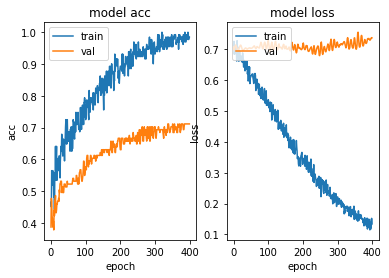

In [15]:
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(IMG_PATH)
plt.show()

train_dataのacc, lossは順調に推移するが、val_dataに対しては一定幅で同水準に留まる。
元データが少ないから？(https://datascience.stackexchange.com/questions/37815/what-to-do-if-training-loss-decreases-but-validation-loss-does-not-decrease)

In [ ]:
predict_answers = model.predict_classes(X_test)

In [ ]:
plt.figure(figsize=(50,50))
columns = 5
cat_wrong_cnt = 0
dog_wrong_cnt = 0
for i, image in enumerate(X_test):
    plt.subplot(len(X_test) / columns + 1, columns, i + 1)
    predicted_num = predict_answers[i]
    answer = y_test[i]
    
    if predicted_num != answer:
        if predicted_num == 0:
            label = 'cat'
            cat_wrong_cnt += 1
        else:
            label = 'dog'
            dog_wrong_cnt += 1
        plt.title(label, fontsize=40)
        plt.axis('off')
        plt.imshow(image)

print('answer is dog, but cat is predicted:', cat_wrong_cnt)
print('answer is cat, but dog is predicted:', dog_wrong_cnt)

画像加工 min val-loss, filters, dropout, note<br>
gray 0.69, 16, 0.3, epoch50くらいで過学習<br>
color 0.59, 16, 0.3, epoch180くらいで過学習<br>
aug, 0.61, 16, 0.3, epoch180くらいで過学習<br>
gray & aug<br>